In [3]:
#import 

import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import random
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import pandas as pd 

## Fonctions

In [4]:
def lire_alpha_digit(data, L):
    """Extracts and binarizes specific characters from the dataset."""
    X=data['dat'][L[0]]
    for i in range(1,len(L)) :
        X_bis=data['dat'][L[i]]
        X=np.concatenate((X,X_bis),axis=0)
    n=X.shape[0]
    X=np.concatenate(X).reshape((n,320))
    return X

def binarize_data(X, threshold=0.5):
    """Binarizes input data by applying a threshold."""
    return (X > threshold) 
    
def lire_mnist(labels_to_use=[0,1,2]):

    #    labels_to_use = [0, 1, 2]
    data = pd.read_csv('/kaggle/input/mnist-in-csv/mnist_train.csv')
 
    filtered_data = data[data['label'].isin(labels_to_use)]
    
    images = filtered_data.drop('label', axis=1).values  # shape: (N, 784)
    n = images.shape[0]
    X=np.concatenate(images).reshape((n,784))
    X = binarize_data(X)

    return X

def display_images(images, size):
    for image in images:
        image = image.reshape(size)
        plt.imshow(image, cmap='gray')
        plt.show() 

class RBM:
    def __init__(self, p, q, device='cpu'):
        self.device = device
        self.a = torch.zeros(p, device=self.device)
        self.b = torch.zeros(q, device=self.device)
        self.W = torch.randn(p, q, device=self.device) * 0.01  # Normal distribution with variance 0.01
        
    def entree_sortie(self, V):
        """Computes hidden activations from visible layer."""
        return torch.sigmoid(V @ self.W + self.b)
    
    def sortie_entree(self, H):
        """Computes visible reconstructions from hidden layer."""
        return torch.sigmoid(H @ self.W.T + self.a)
    
    def train(self, X, learning_rate, len_batch, n_epochs, verbose=False):
        p, q = self.W.shape
        X = torch.tensor(X, dtype=torch.float32, device=self.device)

        losses = []
        weights = []

        for epoch in range(n_epochs):
            perm = torch.randperm(X.size(0), device=self.device)
            X = X[perm]  # Shuffle the dataset
            
            for i in range(0, X.size(0), len_batch):
                X_batch = X[i:i+len_batch]
                
                # Positive phase
                pH_V0 = self.entree_sortie(X_batch)
                H0 = (torch.rand_like(pH_V0) < pH_V0).float()
                
                # Negative phase (Gibbs sampling)
                pV_H0 = self.sortie_entree(H0)
                V1 = (torch.rand_like(pV_H0) < pV_H0).float()
                pH_V1 = self.entree_sortie(V1)
                
                # Compute gradients
                da = torch.sum(X_batch - V1, dim=0)
                db = torch.sum(pH_V0 - pH_V1, dim=0)
                dW = X_batch.T @ pH_V0 - V1.T @ pH_V1
                
                # Update parameters
                self.a += learning_rate * da
                self.b += learning_rate * db
                self.W += learning_rate * dW
                
                weights.append(self.W.mean().item())
            
            # Compute reconstruction loss
            H = self.entree_sortie(X)
            X_rec = self.sortie_entree(H)
            loss = F.mse_loss(X, X_rec).item()
            losses.append(loss)
            
            if epoch % 10 == 0 and verbose:
                print(f"Epoch {epoch}/{n_epochs} - Loss: {loss:.6f}")
        
        # Plot loss evolution
        #plt.plot(losses)
        #plt.xlabel('Epochs')
        #plt.ylabel('Loss')
        #plt.title('Loss Evolution')
        #plt.show()
        
        #print("Final Loss:", losses[-1])
        
        #plt.plot(weights)
        #plt.xlabel('Epochs')
        #plt.ylabel('Mean Weights')
        #plt.show()

        return losses, losses[-1]
    
    def generate_images(self, nb_images, nb_iter, img_size):
        """Generates images using Gibbs sampling."""
        p, q = self.W.shape
        images = []
        
        for _ in range(nb_images):
            v = (torch.rand(p, device=self.device) < 0.5).float()
            for _ in range(nb_iter):
                h = (torch.rand(q, device=self.device) < self.entree_sortie(v)).float()
                v = (torch.rand(p, device=self.device) < self.sortie_entree(h)).float()
            images.append(v.cpu().numpy().reshape(img_size))
        
        return images



# Affichage des images

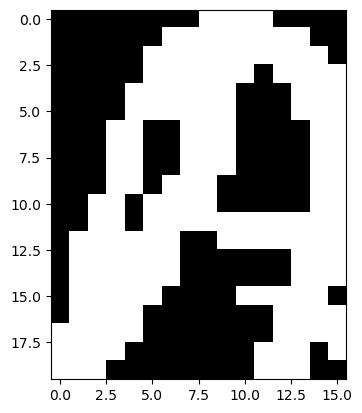

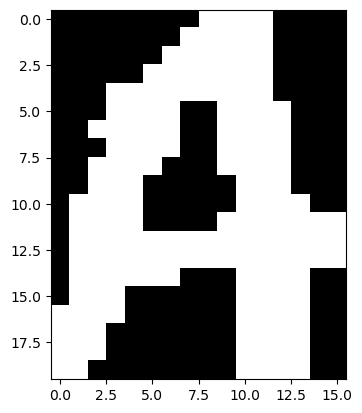

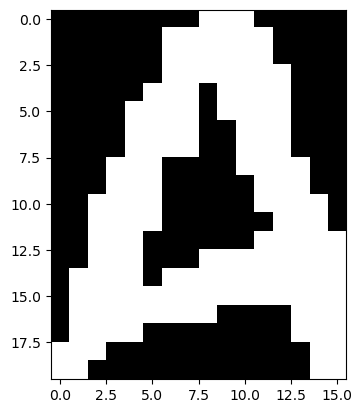

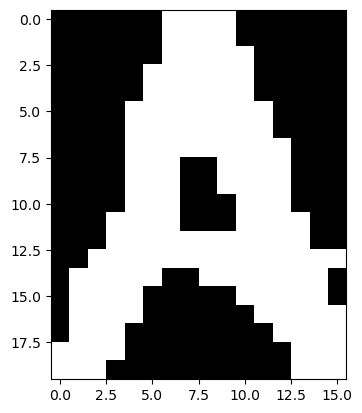

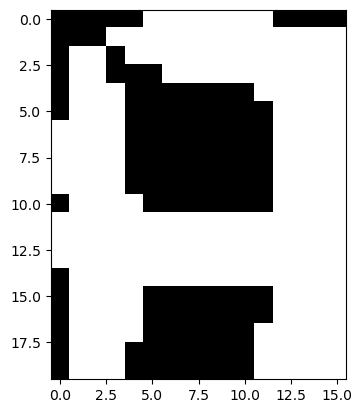

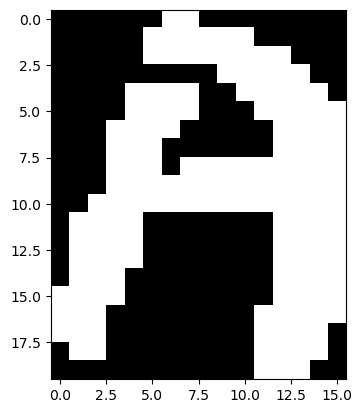

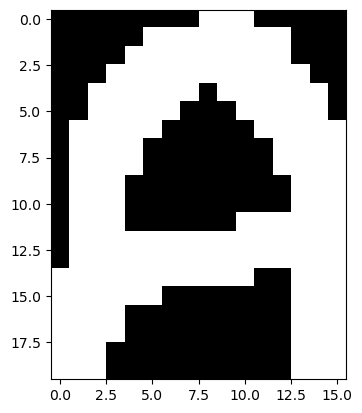

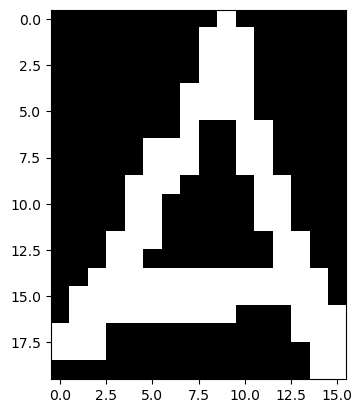

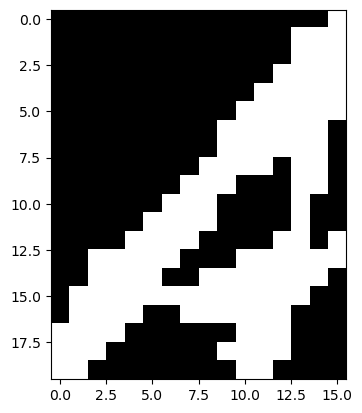

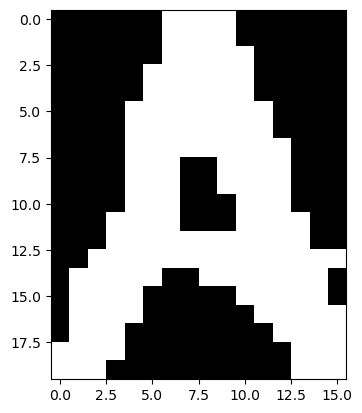

In [14]:
# Load du dataset et affichage des images 
binary_digs = True 

N_chiffres = 1

if binary_digs :
    data = scipy.io.loadmat('/kaggle/input/binary-alpha-digits/binaryalphadigs.mat')
    size = data['dat'][0][0].shape
    #l'indice 0 est le charactère 0 
    L = [10+k for k in range(N_chiffres)]
    X = lire_alpha_digit(data, L)
else: 
    #MNIST 
    L = [k for k in range(N_chiffres)]
    size = (28,28)
    X = lire_mnist(L)

for _ in range(10):
    i = np.random.choice(X.shape[0])
    display_images([X[i]], size)


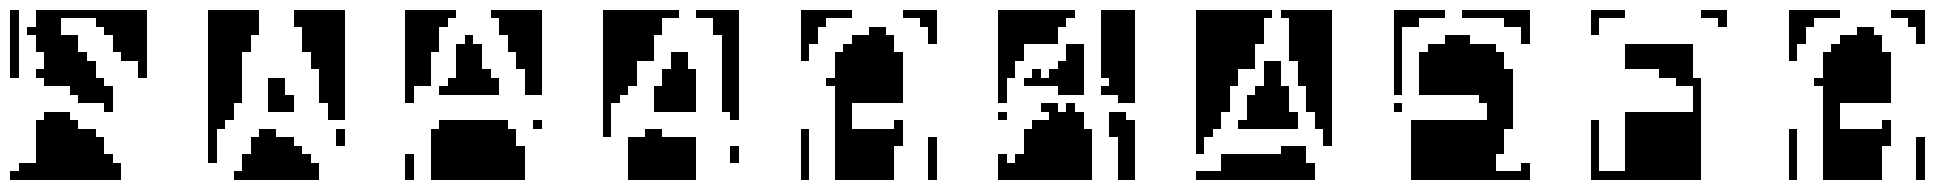

In [16]:
num_images = 10  # Number of images to display
selected_images = [X[np.random.choice(X.shape[0])].reshape(size) for _ in range(num_images)]

# Create a single-row plot
fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))  # Adjust size as needed

for ax, img in zip(axes, selected_images):
    ax.imshow(img, cmap='gray')  # Change cmap if images are colored
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.savefig("selected_images_row.png", dpi=300, bbox_inches='tight')  # Save the figure
plt.show()

# Etude

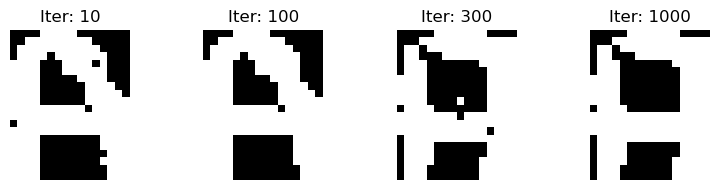

In [18]:
import matplotlib.pyplot as plt

# enrtianement 
p = X.shape[1]
rbm = RBM(p=p, q=200, device='cpu')
loss, loss_finale = rbm.train(X, learning_rate=1e-2, len_batch=10, n_epochs=nb_epochs, verbose=False)

# choix du nb d'itération du sampleur 
iter_values = [10, 100, 300, 1000]

# Create a figure for displaying the generated images
fig, axes = plt.subplots(nrows=1, ncols=len(iter_values), figsize=(len(iter_values) * 2, 2))

for i, iter_gen in enumerate(iter_values):
    generated_image = rbm.generate_images(nb_images=1, nb_iter=iter_gen, img_size=size)[0]

    # affichage de l'image
    ax = axes[i]
    ax.imshow(generated_image, cmap='gray')
    ax.axis('off')
    ax.set_title(f"Iter: {iter_gen}")

    plt.imsave(f"Generated_Iter_{iter_gen}.png", generated_image, cmap='gray')

plt.tight_layout()
plt.savefig(f"Comparison_UnitesCachées_{n_unites_caches}.png", dpi=300, bbox_inches='tight')  # Save full comparison
plt.show()


Dataset: BinaryAlpha | Lettres: 1 | Unités cachées: 500 | Unités/lettres : 500.0 Alpha: 0.01 | Epochs: 200
--> Loss finale: 3388.5 x 10e-5



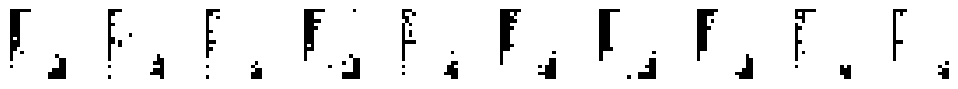

Dataset: MNIST | Lettres: 1 | Unités cachées: 500 | Unités/lettres : 500.0 Alpha: 0.01 | Epochs: 200
--> Loss finale: 193.2 x 10e-5



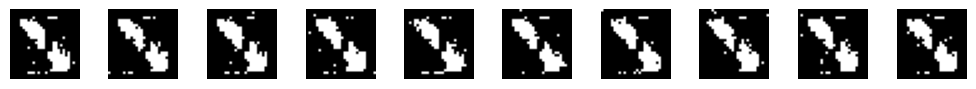

In [22]:
# Grille sur le choix de la base de données : 
# True -> binary alpha digits, False -> MNIST
#datasets = [("BinaryAlpha", True)]
datasets = [("BinaryAlpha", True), ("MNIST", False)]
# Nombre de caractères (lettres/chiffres) à apprendre
n_lettres_list = [1]

# Nombre d'unités cachées
n_unites_caches_list = [500]

# Taux d'apprentissage (alpha)
alpha_list = [1e-2] #[5 * k/1000 for k in range(1,4)]

# Nombre d'époques
nb_epochs_list = [200]

# Nombre d'itérations pour la génération d'images
iter_generation = 1000  # par exemple

# Nombre d'images générées pour l'analyse
nb_images_gen = 10

# =============================================================================
# Boucle d'expérimentation
# =============================================================================

results = []  # liste pour stocker les résultats de chaque expérience

for dataset_name, binary_digs in datasets:
    for n_lettres in n_lettres_list:
        # Chargement des données en fonction du dataset et du nombre de caractères
        if binary_digs:
            data = scipy.io.loadmat('/kaggle/input/binary-alpha-digits/binaryalphadigs.mat')
            size = data['dat'][0][0].shape  # taille de l'image (ex. (20,16))
            L = [k+1 for k in range(n_lettres)]
            X = lire_alpha_digit(data, L)
        else:
            size = (28, 28)
            L = [k+1 for k in range(n_lettres)]
            X = lire_mnist(L)
        
        # Nombre d'unités visibles (taille de l'image aplatie)
        p = X.shape[1]
        
        for n_unites_caches in n_unites_caches_list:
            for alpha in alpha_list:
                for nb_epochs in nb_epochs_list:
                    print(f"Dataset: {dataset_name} | Lettres: {n_lettres} | Unités cachées: {n_unites_caches} | Unités/lettres : {n_unites_caches/n_lettres:.1f} "
                          f"Alpha: {alpha} | Epochs: {nb_epochs}")
                    
                    # Création du modèle RBM
                    rbm = RBM(p=p, q=n_unites_caches, device='cpu')
                    
                    # Entraînement du modèle
                    loss, loss_finale = rbm.train(X, learning_rate=alpha, len_batch=10, n_epochs=nb_epochs, verbose=False)
                    
                    # Génération d'images
                    generated_images = rbm.generate_images(nb_images=nb_images_gen, 
                                                           nb_iter=iter_generation, 
                                                           img_size=size)
                    
                    # Enregistrement des résultats
                    results.append({
                        'Dataset': dataset_name,
                        'n_lettres': n_lettres,
                        'HiddenUnits': n_unites_caches,
                        'LearningRate': alpha,
                        'Epochs': nb_epochs,
                        'FinalLoss': loss_finale,
                        'losses' : loss,
                        'GeneratedImages': generated_images
                    })
                    
                    print(f"--> Loss finale: {loss_finale*10e5:.1f} x 10e-5\n")

                    # Display generated images
                    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 1))
                    
                    for i, ax in enumerate(axes.flat):
                        if i < len(generated_images):
                            ax.imshow(generated_images[i], cmap='gray')
                            ax.axis('off')
                        else:
                            ax.set_visible(False)
                    
                    plt.tight_layout()
                    plt.savefig(f"Lettres: {n_lettres} | Unités cachées: {n_unites_caches}.png")
                    plt.show()


In [8]:
# Conversion des résultats en DataFrame pour analyse
df_results2 = pd.DataFrame(results)
print("\nRésumé des expériences :")
print(df_results2[['Dataset', 'n_lettres', 'HiddenUnits', 'LearningRate', 'Epochs', 'FinalLoss']])


Résumé des expériences :
        Dataset  n_lettres  HiddenUnits  LearningRate  Epochs  FinalLoss
0   BinaryAlpha          1          100          0.01    1000   0.000211
1   BinaryAlpha          1          200          0.01    1000   0.000043
2   BinaryAlpha          1          300          0.01    1000   0.000019
3   BinaryAlpha          1          400          0.01    1000   0.000011
4   BinaryAlpha          4          100          0.01    1000   0.001209
5   BinaryAlpha          4          200          0.01    1000   0.000079
6   BinaryAlpha          4          300          0.01    1000   0.000027
7   BinaryAlpha          4          400          0.01    1000   0.000013
8   BinaryAlpha          7          100          0.01    1000   0.002138
9   BinaryAlpha          7          200          0.01    1000   0.000080
10  BinaryAlpha          7          300          0.01    1000   0.000024
11  BinaryAlpha          7          400          0.01    1000   0.000012
12  BinaryAlpha         1

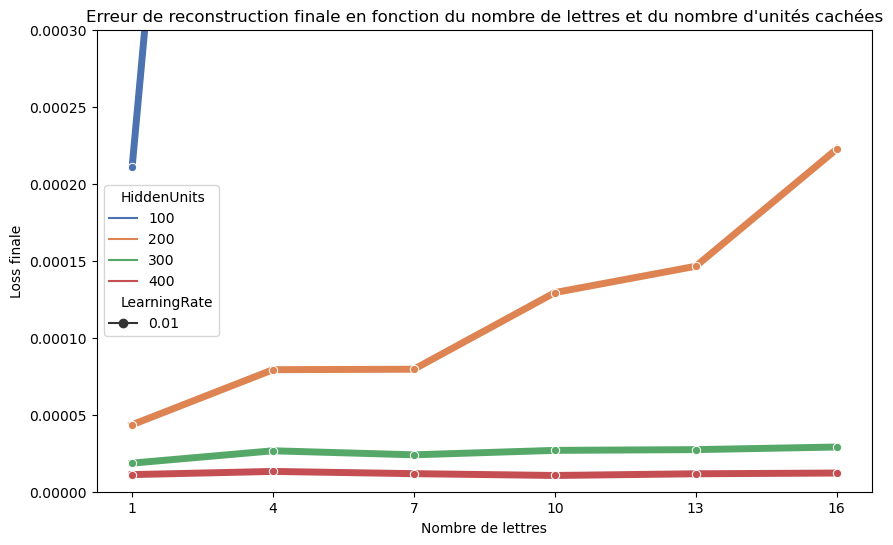

In [13]:
import numpy as np
import seaborn as sns 

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results2, 
             x='n_lettres', 
             y='FinalLoss',
             hue='HiddenUnits', 
             style='LearningRate', 
             markers=True, 
             dashes=False,
             linewidth=5,
            palette="deep")  # Augmente l'épaisseur des lignes

plt.title("Erreur de reconstruction finale en fonction du nombre de lettres et du nombre d'unités cachées")
plt.xlabel("Nombre de lettres")
plt.ylabel("Loss finale")
plt.ylim(0, 3e-4)  # Limite l'axe des ordonnées entre 0 et 3e-4

# Force l'axe X à n'afficher que les entiers
plt.xticks(np.unique(df_results2['n_lettres']))  
plt.savefig("Etude.png")
plt.show()
